In [1]:
import random
import numpy as np
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt

### I want to try serial dependece by weighted average in internal representation of confidence

In [8]:
###### FLEMING'S FUNCTION MODIFIED
def compute_meta_conf_serialdependence(xp, a, sigma_act, sigma_conf, rho):
    
    dhat = np.array([-1, 1])
    mu_x_xp_dhat = np.zeros((2, len(xp)))
    var_x_xp_dhat = np.zeros(len(xp))
    rho_vec = np.full(len(xp), rho)
    sigA_vec = np.full(len(xp), sigma_act)
    sigP_vec = np.full(len(xp), sigma_conf)
    
    Tol = 10e-4

    for dhati in range(2):
        dhat_vec = np.full(len(xp), dhat[dhati])
        
        mu_x_xp_dhat[dhati, :] = dhat_vec + (sigA_vec / sigP_vec) * rho_vec * (xp - dhat_vec)
        var_x_xp_dhat = (1 - rho_vec**2) * sigA_vec**2
        
        if a == 1:
            p_a_dhat_xp = 1 - norm.cdf(0, mu_x_xp_dhat[dhati, :], np.sqrt(var_x_xp_dhat))
        else:
            p_a_dhat_xp = norm.cdf(0, mu_x_xp_dhat[dhati, :], np.sqrt(var_x_xp_dhat))
        
        lik_d = norm.pdf(xp, dhat_vec, sigP_vec)
        
        if dhati == 0:
            p_a_dhat_xp_full = p_a_dhat_xp
            lik_d_full = lik_d
        else:
            p_a_dhat_xp_full = np.vstack((p_a_dhat_xp_full, p_a_dhat_xp))
            lik_d_full = np.vstack((lik_d_full, lik_d))
    
    # manage probability
    p_a_dhat_xp_full = np.clip(p_a_dhat_xp_full, Tol, None)
    lik_d_full = np.clip(lik_d_full, Tol, None)
    
    lik_d_full = lik_d_full / np.sum(lik_d_full, axis=0, keepdims=True)
    p_dhat_xp_a = p_a_dhat_xp_full * lik_d_full
    p_dhat_xp_a = p_dhat_xp_a / np.sum(p_dhat_xp_a, axis=0, keepdims=True)
    
    # Conf = p(a=d)
    if a == 1:
        conf = p_dhat_xp_a[1, :]
    else:
        conf = p_dhat_xp_a[0, :]
    
    return conf

In [29]:
theta = [0/6, 1/6, 2/6, 3/6, 4/6, 5/6, 6/6] # I changed a little, because is very easy so far 
sigmaAct = 2.5  # 1
sigmaConf = 2.5 # 1
rho = 0.5 # 0.5
bigSigma = np.array([[sigmaAct**2, rho * sigmaAct * sigmaConf], [rho * sigmaAct * sigmaConf, sigmaConf**2]])

N = 100  # N trials

xa = np.empty(N)
xp = np.empty(N)
xp_serialDependence = np.full( N, 111.0)
d = np.empty(N)
a = np.empty(N)
secondOrder_mean_cor = np.empty(N)
secondOrder_mean_cor_serialDependence =  np.full( N, 111.0)
last_xp = np.empty(N)
first_trial = True

for i in range(N):
    current_theta = random.choice(theta)
    
    d[i] = 1 if np.random.rand() > 0.5 else -1
    
    r = multivariate_normal.rvs(mean=[d[i] * current_theta, d[i] * current_theta], cov=bigSigma)
    
    xa[i] = r[0]
    xp[i] = r[1]
    
    if xa[i] > 0:
        a[i] = 1
        flip_a = 1
    else:
        a[i] = -1
        flip_a = 0

    if i == 0:
        secondOrder_mean_cor[i] = compute_meta_conf_serialdependence(np.array([xp[i]]), flip_a, sigmaAct, sigmaConf, rho)[0]
    else:
        secondOrder_mean_cor[i] = compute_meta_conf_serialdependence(np.array([xp[i]]), flip_a, sigmaAct, sigmaConf, rho)[0]
    
    if first_trial == False:
        
        last_xp[i] = xp[i-1]
        xp_serialDependence[i] = xp[i] * 0.5 + last_xp[i] * 0.5
        
        if i == 0:
            secondOrder_mean_cor_serialDependence[i] = compute_meta_conf_serialdependence(np.array([xp_serialDependence[i]]), flip_a, sigmaAct, sigmaConf, rho)[0]
        else:
            secondOrder_mean_cor_serialDependence[i] = compute_meta_conf_serialdependence(np.array([xp_serialDependence[i]]), flip_a, sigmaAct, sigmaConf, rho)[0]


    first_trial = False
    


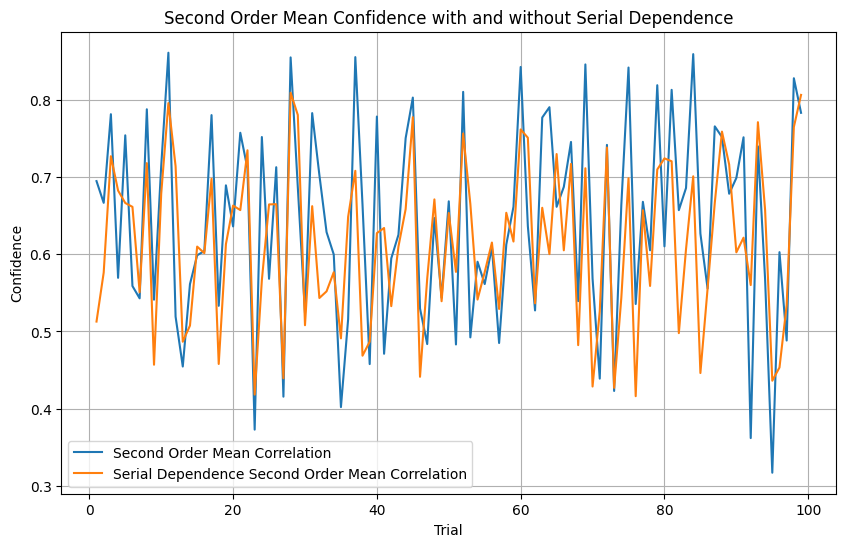

In [30]:
# Eliminar el primer valor de secondOrder_mean_cor
secondOrder_mean_cor_adj = secondOrder_mean_cor[1:]
secondOrder_mean_cor_serialDependence_adj = secondOrder_mean_cor_serialDependence[1:]

# Crear el plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, N), secondOrder_mean_cor_adj, label='Second Order Mean Correlation')
plt.plot(range(1,N), secondOrder_mean_cor_serialDependence_adj, label='Serial Dependence Second Order Mean Correlation')
plt.xlabel('Trial')
plt.ylabel('Confidence')
plt.title('Second Order Mean Confidence with and without Serial Dependence')
plt.legend()
plt.grid(True)
plt.show()